In [1]:

import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2 as cv
import shutil
import json
import random
import math
from zipfile import ZipFile

In [ ]:
#working in the directory where data is unziped

working in the directory where data is unziped

EDA

In [3]:
# Extraction from zip file
fname = 'zipfile provided'
with ZipFile(fname, 'r') as zip:
    zip.extractall()

In [17]:

image_folder = 'Medical mask/Medical mask/Medical Mask/train'

In [6]:
# exploring the given csv file
df  = pd.read_csv('train.csv')
df['classname'].unique()

array(['face_with_mask', 'mask_colorful', 'face_no_mask',
       'face_with_mask_incorrect', 'mask_surgical', 'face_other_covering',
       'scarf_bandana', 'eyeglasses', 'helmet', 'face_shield',
       'sunglasses', 'hood', 'hat', 'goggles', 'hair_net', 'hijab_niqab',
       'other', 'gas_mask', 'balaclava_ski_mask', 'turban'], dtype=object)

In [31]:
len(df)

15412

In [10]:
'''
visualize for each 
'''

no = df[df['classname'] == 'face_no_mask']

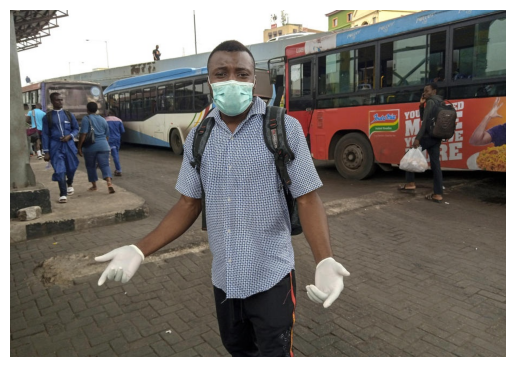

In [22]:
im = plt.imread(image_folder+'/'+no['name'].iloc[5])
plt.axis('off')
plt.imshow(im)

In [23]:
no['name'].iloc[5]

'1987.jpg'

In [35]:
# Reading Annotations from jsonfile
js = 'Medical mask/Medical mask/Medical Mask/annotations'
with open(js+'/'+'1987.jpg.json', 'r') as f:
    data = json.load(f)

In [26]:
data

{'FileName': '1987.jpg',
 'NumOfAnno': 4,
 'Annotations': [{'isProtected': False,
   'ID': 998429531988432512,
   'BoundingBox': [365, 67, 464, 199],
   'classname': 'face_with_mask',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 467992980447121984,
   'BoundingBox': [72, 150, 103, 191],
   'classname': 'face_no_mask',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 739005464801042432,
   'BoundingBox': [367, 127, 456, 198],
   'classname': 'mask_surgical',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 315462342033672192,
   'BoundingBox': [764, 138, 794, 169],
   'classname': 'face_no_mask',
   'Confidence': 1,
   'Attributes': {}}]}

In [38]:
#Visualization

def show(data):
    path = os.path.join(image_folder, data['FileName'])
    k = cv.imread(path)
    for i in data['Annotations']:
        x1, y1, x2, y2 = i['BoundingBox']
        text = i['classname']
    
        cv.rectangle(k, (x1,y1), (x2,y2),(255,0,255), 2 )
        cv.putText(k,text, (x1,y1),cv.FONT_HERSHEY_COMPLEX,0.8,(255,0,255), 2)
    cv.imshow('image', k)
    cv.waitKey(0)
    cv.destroyAllWindows()

In [39]:
show(data)

In [27]:
# converting annotations into yolo format
js = r'Medical mask/Medical mask/Medical Mask/annotations'
i_dir = r'Medical mask/Medical mask/Medical Mask/train'
d_dir = r'Medical mask/Medical mask/Medical Mask/yolo_ann'
mask = ['face_with_mask','scarf_bandana','face_with_mask_incorrect', 'gas_mask', 'balaclava_ski_mask' ]
def yolo_annotations(a_dir, i_dir, d_dir):
    image_list = os.listdir(a_dir)
    
    for ann in range(len(image_list)):
        a_path = os.path.join(a_dir,image_list[ann])

        with open(a_path, 'r') as f:
            data = json.load(f)
        
        i_path = os.path.join(i_dir, data['FileName'])
        d_path = os.path.join(d_dir, data['FileName'].split('.')[0]+'.txt')
        image = plt.imread(i_path)
        X, Y = image.shape[:2]
        obj = []
        for annotation in data['Annotations']:
            if annotation['classname'] in mask:
                x1, y1, x2, y2 = annotation['BoundingBox']
                xc = (x1 + (x2-x1)/2)/Y
                yc = (y1 +(y2-y1)/2)/X
                h = (x2-x1)/Y
                w = (y2-y1)/X
                cl = 1
                obj.append(f'{cl} {round(xc,7)} {round(yc,7)} {round(w,7)} {round(h,7)}')
            elif annotation['classname'] == 'face_no_mask':
                x1, y1, x2, y2 = annotation['BoundingBox']
                xc = (x1 + (x2-x1)/2)/Y
                yc = (y1 +(y2-y1)/2)/X
                h = (x2-x1)/Y
                w = (y2-y1)/X
                cl = 0
                obj.append(f'{cl} {round(xc,7)} {round(yc,7)} {round(w,7)} {round(h,7)}')
                
        with open(d_path, 'w') as f:
            f.write('\n'.join(obj))
                
                
                

In [28]:
yolo_annotations(js,i_dir, d_dir)

**Creating validation and training split**

Created a directory name yolo which has sub-directories train and val within which there are two more directory - images and val

  

In [ ]:
'''
yolo
|
-- train
    |
    -- images
    -- val
-- val
    |
    -- images
    -- val'''  

In [78]:
# defining paths
src_ann = 'Medical mask/Medical Mask/Medical Mask/yolo_ann'
src_im =  'Medical mask/Medical Mask/Medical Mask/train'
train_an_dir = 'yolo/train/labels'
val_an_dir = 'yolo/val/labels'
train_im_dir='yolo/train/images'
val_im_dir= 'yolo/val/images'

In [79]:
# creating function to randomize and split the data into ration 80:20
def train_val(src_ann, src_im, train_an_dir, val_an_dir, ratio = 0.8):
    train_im_dir='yolo/train/images'
    val_im_dir= 'yolo/val/images'
    im_list = os.listdir(src_im)
    n_split = math.ceil(len(im_list)*ratio)
    random.shuffle(im_list)
    train_im = im_list[:n_split]
    val_im = im_list[n_split:]
    

    for i in im_list:
        src_a = os.path.join(src_ann, i.split('.')[0]+'.txt')
        src_i = os.path.join(src_im, i)
        
        if i in train_im:
            dst_an = train_an_dir +'/'+ i.split('.')[0]+'.txt'
            dst_im = train_im_dir +'/'+i
            
            shutil.copy(src_i, dst_im)
            shutil.copy(src_a, dst_an)
        else: 
            dst_an = val_an_dir +'/'+ i.split('.')[0]+'.txt'
            dst_im = val_im_dir+'/'+ i
            shutil.copy(src_i, dst_im)
            shutil.copy(src_a, dst_an)
            
    
    

In [131]:
train_val(src_ann, src_im, train_an_dir, val_an_dir)

In [132]:
len(os.listdir(train_im_dir)), len(os.listdir(val_im_dir))


(3461, 865)

In [135]:
# resizing the images to 640x640 for yolo 
for i in os.listdir('yolo/val/images'):
    im_path = 'yolo/val/images'+'/'+i
    save_path = 'yolo/val/resize_images' +'/'+i
    im = cv.imread(im_path)
    resized = cv.resize(im, (640,640))
    cv.imwrite(save_path, resized)
    

In [136]:
for i in os.listdir('yolo/train/images'):
    im_path = 'yolo/train/images'+'/'+i
    save_path = 'yolo/train/resize_images' +'/'+i
    im = cv.imread(im_path)
    resized = cv.resize(im, (640,640))
    cv.imwrite(save_path, resized)

In [ ]:
shutil.rmtree('yolo/train/images')
shutil.rmtree('yolo/val/images')
os.rename('yolo/train/resize_images','yolo/train/images')
os.rename('yolo/val/resize_images', 'yolo/val/images')

In [ ]:
os.chdir('yolo')

In [ ]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')

In [ ]:
result = model.train(data = 'data.yaml', epochs = 30,imgsz = 640, batch = 16)